In [412]:
import scipy.io
import scipy.signal
import scipy.fft
import matplotlib.pyplot as plt
import numpy as np

In [413]:
#Loading the audio file
signal = scipy.io.wavfile.read('signal.wav')
numSamples = len(signal[1])
print('Sample rate is:', signal[0], 'and the number of signals is:', numSamples)
print('This corresponds to', numSamples/signal[0], 'seconds')

Sample rate is: 16000 and the number of signals is: 18091
This corresponds to 1.1306875 seconds


In [414]:
#Mean subtraction
mean = np.mean(signal[1])
print(mean)
meanSub = signal[1] - mean

11756.525786302582


In [415]:
#Pre-emphasis
b = 0.97 #given constant
np.insert(meanSub, 0, 0)
preEmp = np.array([meanSub[i]-b*meanSub[i-1] for i in range(1, numSamples-1)])
print(preEmp)


[ 279946.55422641 -120352.58577359  -41547.25577359 ...  102152.87422641
 -137258.38577359 -149305.20577359]


In [416]:
#Computing frames
#Window length 𝐿 set to 25 milliseconds: this is (25/1000)/(1/16000) = 400 samples
#Window shift 𝑆 set to 10 milliseconds: this is (10/1000)/(1/16000) = 160 samples
L = 400
S = 160
#dimensions of the return array are ceil((numSamples-L)/S) rows by L samples
frames = []
k = 0
pad = False
while not pad:
    frames.append([])
    n = 0
    while  n<L:
        ind = k*S+n
        sample = 0
        if  ind<len(preEmp):
            sample = preEmp[ind]
        else:
            pad = True
        frames[k].append(sample)
        n+=1
    k+=1
frames = np.array(frames)
print(frames.shape)

(112, 400)


In [417]:
#Applying window function
window = scipy.signal.hamming(L)
#print(window)
for row in range(len(frames)):
    frames[row]*=window
print(frames.shape)

(112, 400)


In [418]:
#Computing the Fourier transform
N = 512 #number of DFT points, given
fourier = scipy.fft.fft(frames, N)
print(fourier)

[[ 2830872.47675556       -0.j
   -558968.07040563  -967207.34636698j
     90147.26160632  -771976.08684657j ...
   -605383.31591248  +267144.64227308j
     90147.26160632  +771976.08684657j
   -558968.07040563  +967207.34636698j]
 [ 1989031.58566385       -0.j
   -638824.51591104 -1454866.45202947j
   -833715.20543567  +780577.14030785j ...
   1369994.32045942  +159163.18673334j
   -833715.20543567  -780577.14030785j
   -638824.51591104 +1454866.45202947j]
 [  418363.81492086       -0.j
     28513.48643391  -248899.89607843j
   -310481.35423204  -116500.46573139j ...
    931390.15408163  -996523.52086515j
   -310481.35423204  +116500.46573139j
     28513.48643391  +248899.89607843j]
 ...
 [ -713476.74749506       -0.j
  -3224694.93325647 +3903722.41757171j
   6916959.74749869 +3531423.69364916j ...
   2792374.73180744 +7666101.27461313j
   6916959.74749869 -3531423.69364916j
  -3224694.93325647 -3903722.41757171j]
 [ 8399684.50373869       -0.j
  -4550408.39595503   -43883.88874759j
 

In [419]:
#Computing the magnitude and power spectra
magnitude = np.abs(fourier)
print(magnitude)
power = np.square(magnitude)
print(power.shape)

[[ 2830872.47675556  1117110.26966869   777221.72347282 ...
    661706.29366842   777221.72347282  1117110.26966869]
 [ 1989031.58566385  1588940.89108746  1142095.31815249 ...
   1379208.96099982  1142095.31815249  1588940.89108746]
 [  418363.81492086   250527.79721315   331618.80200223 ...
   1364018.60205705   331618.80200223   250527.79721315]
 ...
 [  713476.74749506  5063369.04896551  7766291.61521661 ...
   8158827.45224225  7766291.61521661  5063369.04896551]
 [ 8399684.50373869  4550619.997942    1231470.51488752 ...
   4204315.65953491  1231470.51488752  4550619.997942  ]
 [15595388.91309609 14038095.94793538 11386588.08049257 ...
  10057161.60033826 11386588.08049257 14038095.94793538]]
(112, 512)


(23, 257)
(112, 23)


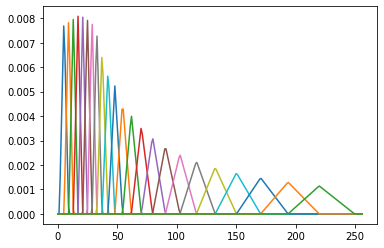

In [420]:
#Mel-filterbank application
mel_filters = np.array(np.load('mel_filters.npy'))
plt.plot(mel_filters.T)
print(mel_filters.shape)
mel = np.matmul(power[:,:257], np.swapaxes(mel_filters, 0, 1))
print(mel.shape)

In [421]:
#taking the log
mellog = np.maximum(np.full(mel.shape, -50), np.log(mel))
print (mellog.shape)

(112, 23)


In [422]:
#Computing the DCT and “liftering”:
c = np.zeros((mellog.shape[0], 13))
for window in range(c.shape[0]):
    for i in range(c.shape[1]):
        val = np.sum(mellog[window]*np.cos((np.array(range(mellog.shape[1]))+0.5)*(np.pi*i/23)))
        c[window][i] = val
print(c.shape)
print(c)

(112, 13)
[[ 5.39047398e+02 -1.88685180e+01  1.07517934e+00 ...  3.45698627e+00
   3.08642436e+00 -8.97549482e-01]
 [ 5.39321231e+02 -1.46728236e+01  2.93520982e+00 ...  1.69609591e+00
   2.85238975e+00  3.67674935e+00]
 [ 5.42209866e+02 -1.27631183e+01  3.78885046e+00 ...  1.85293369e+00
   5.44029391e+00  3.59812471e+00]
 ...
 [ 5.53174233e+02 -4.00653277e+00  1.15639278e+01 ...  6.65937285e-01
  -8.20534569e-01  1.78971848e+00]
 [ 6.34223178e+02 -3.32119165e+01 -6.29091639e+00 ...  1.50696231e+00
  -1.17863057e+00  1.42235144e+00]
 [ 6.41391732e+02 -3.17919523e+01 -4.95695450e+00 ...  8.00065006e-01
  -5.67156750e-01  2.27396675e+00]]


In [423]:
#putting it all together

(13, 112)


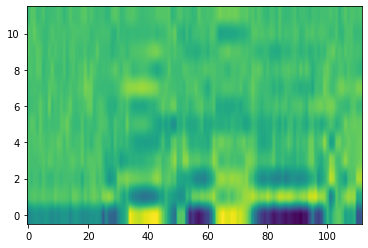

In [424]:
#Visualizing MFCC features
cdata = np.swapaxes(c, 0, 1)
print(cdata.shape)
plt.imshow(cdata[1:13], origin='lower', aspect='auto')

In [425]:
#Calculating diffs and MSE
reference = np.load('reference_mfcc.npy')
diffs = np.absolute(c-reference)
print(diffs)
mse = np.square(diffs).mean()
print(mse)

[[7.40232268e-02 3.75111879e-02 3.21652515e-02 ... 3.24017262e-02
  4.51705935e-02 9.45944247e-03]
 [3.20781001e-02 2.47220376e-02 2.18824723e-02 ... 7.83576283e-03
  2.39031537e-02 2.58796725e-02]
 [2.78107187e-02 2.87957693e-02 3.18185680e-02 ... 3.20334723e-03
  1.29192726e-02 6.53694197e-03]
 ...
 [4.73558754e-02 4.09433601e-02 2.33047214e-02 ... 3.40326894e-02
  1.69752676e-02 2.52005081e-04]
 [4.37011632e-01 4.77586762e-02 2.32322490e-02 ... 4.65050913e-03
  1.43293782e-03 2.82376759e-04]
 [3.29151512e-01 6.21830100e-02 3.75647541e-02 ... 1.49442770e-02
  4.09824525e-03 7.39480886e-03]]
0.1323263662626633


(23, 112)


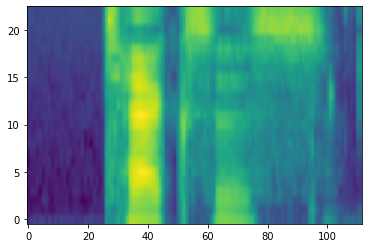

In [426]:

#printing log mel mfsc
mellogdata = np.swapaxes(mellog, 0, 1)
print(mellogdata.shape)
plt.imshow(mellogdata, origin='lower', aspect='auto')

(512, 112)


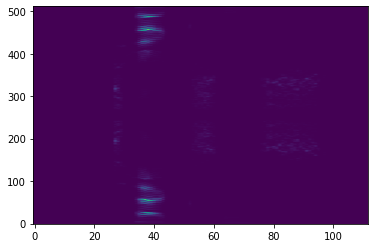

In [427]:
#printing log power spectra
logpower = np.maximum(np.full(power.shape, -50), np.log(power))
logpowerdata = np.swapaxes(power, 0, 1)
print(logpowerdata.shape)
plt.imshow(logpowerdata, origin='lower', aspect='auto')